# Imports

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from statsmodels.graphics.api import abline_plot
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

In [2]:
!pip install jax jaxlib numpyro

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.7/355.7 kB 6.3 MB/s eta 0:00:00


In [3]:
rng = np.random.default_rng(0)

# Utility functions



In [20]:
def get_data(filename):
  data = pd.read_csv(filename)
  return convert_detection_ratio(data)


In [21]:
def combine_conditions(barefoot_df, shod_df):
  barefoot_df["condition"] = 0
  shod_df["condition"] = 1
  return pd.concat([barefoot_df, shod_df])

In [22]:
def convert_detection_ratio(df):
  # convert string percentages to float numbers
  for col in df.columns:
      if col in ["Participant ID ", "condition"]:
          continue
      df[col] = df[col].str.rstrip('%').astype('float') / 100.0
  return df

In [23]:
def get_detection_threshold(coeffs, threshold):
  x = (np.log(threshold / (1 - threshold)) - coeffs[0]) / coeffs[1]
  return x

In [9]:
def transform_data(df, condition=-1):
  # convert into a dataframe with y column containing 0s and 1s
  rows = []
  for i, row in df.iterrows():
      for col in df.columns:
          if col in ["Participant ID ", "condition"]:
            continue

          idx = row["Participant ID "]

          # if condition is not given explicitly, then it's combined df
          if condition < 0:
            condition = row["condition"]

          # extract the stimulus level
          level = col.split()[0]
          if level[-1].isdigit():
              level = int(level)
          else:
              level = float(level[:-1])

          # populate new dataframe
          detection_ratio = row[col]
          zeros = int((1 - detection_ratio) * 4)
          ones = int(detection_ratio * 4)
          rows.extend([(level, 0, idx, condition)] * zeros)
          rows.extend([(level, 1, idx, condition)] * ones)

  transformed_df = pd.DataFrame(rows, columns=['x', 'y', 'subject_id', 'condition'])
  return transformed_df

In [10]:
def plot_curve(x_axis, y, std_err, dt_x, condition, stimulus, pred_x, pred_y, analysis_type=""):
  fig, ax = plt.subplots()
  ax.errorbar(x_axis, y, yerr=std_err, fmt='o')
  ax.plot(pred_x, pred_y, c='red')
  if analysis_type:
    ax.set_title(f'{analysis_type}. {condition} condition.')
  else:
    ax.set_title(f'{condition} condition.')
  ax.set_ylabel('Average detection ratio')
  ax.set_xlabel(f'{stimulus} distortion')
  ax.axhline(y = 0.75, color = 'gray', linestyle = ':', label=f"DT={dt_x.round(2)}")
  ax.legend(loc='best')
  ax.set_xticks(x_axis)

In [11]:
def get_x_axis(stimulus):
  if stimulus == "Angle":
    return np.linspace(5, 65, num=13)
  else:
    x_axis = np.linspace(1, 2, num=5)
    x_axis = 2 / x_axis
    x_axis = x_axis[::-1]
    return x_axis

In [12]:
def get_y(data):
  data = data.drop(columns=["Participant ID "])
  if "condition" in data.columns:
    data = data.drop(columns=["condition"])
  return data

Testing the function

In [13]:
data = get_data("shod_scale.csv")
data = data.drop(columns=["Participant ID "])
y_data = np.array(data.mean(axis=0))
y_data

array([0.046875, 0.265625, 0.46875 , 0.796875, 0.9375  ])

#Part 1. Reproducing the results using python

## Angle redirection

We have 13 degree points between 5 and 65.
1. Get the x_axis that corresponds to the degrees
2. Find the mean of each column, which will be y_data

In [25]:
def fit_psychometric_curve_logit(filename):
  condition = "".join(filename.split("_")[:-1]).capitalize()
  stimulus = filename.split("_")[-1].split(".")[0].capitalize()

  data = get_data(filename)
  data = get_y(data)
  y_data = np.array(data.mean(axis=0))
  print("Means ", y_data)

  x_axis = get_x_axis(stimulus)
  x_aug = sm.add_constant(x_axis)

  # Fit logistic regression model
  model = sm.GLM(y_data, x_aug, family=sm.families.Binomial())
  result = model.fit()
  coeffs = result.params

  print(result.summary())
  print("\n")
  dt_x = get_detection_threshold(coeffs, 0.75)
  std_err = data.sem()

  print(f"Coefficients: {coeffs}")
  print(f"{stimulus} threshold: {dt_x} \n")

  pred_x = np.linspace(min(x_axis), max(x_axis), num=len(x_axis) * 50)
  pred_x_aug = sm.add_constant(pred_x)
  pred_y = result.predict(pred_x_aug)
  plot_curve(x_axis, y_data, std_err,
             dt_x, condition, stimulus,
             pred_x, pred_y,
             analysis_type="Frequentist approach")


### Barefoot angle

Means  [0.046875 0.140625 0.3125   0.25     0.359375 0.4375   0.53125  0.6875
 0.84375  0.828125 0.921875 1.       0.90625 ]
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   13
Model:                            GLM   Df Residuals:                       11
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4.1939
Date:                Mon, 02 Dec 2024   Deviance:                      0.35145
Time:                        02:38:13   Pearson chi2:                    0.308
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3538
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------

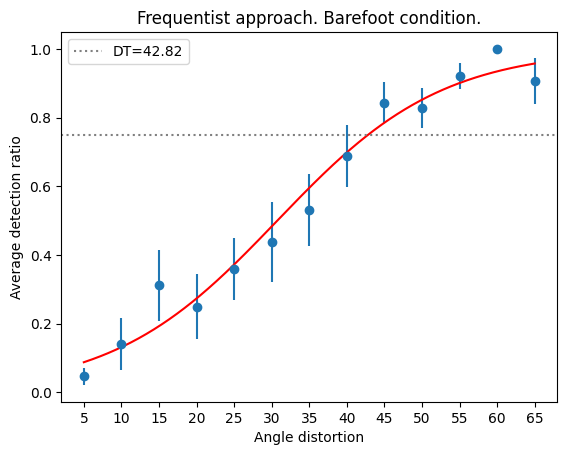

In [26]:
fit_psychometric_curve_logit("barefoot_angle.csv")

### Shod, angle

Means  [0.078125 0.1875   0.140625 0.28125  0.3125   0.421875 0.53125  0.609375
 0.625    0.859375 0.90625  0.96875  0.953125]
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   13
Model:                            GLM   Df Residuals:                       11
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4.2735
Date:                Mon, 02 Dec 2024   Deviance:                      0.20534
Time:                        02:38:16   Pearson chi2:                    0.206
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3460
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----

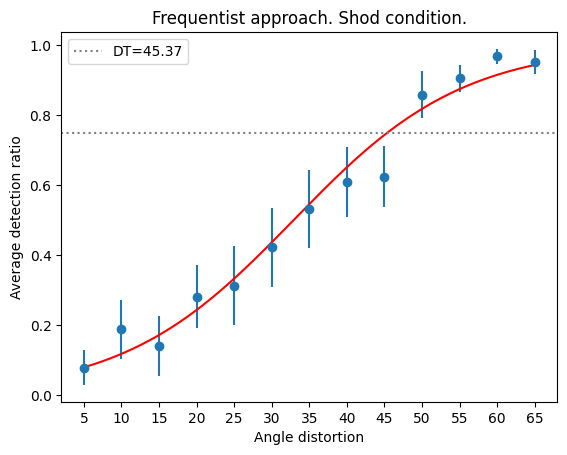

In [27]:
fit_psychometric_curve_logit("shod_angle.csv")

### Barefoot, scale

Means  [0.       0.203125 0.5625   0.796875 0.9375  ]
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                    5
Model:                            GLM   Df Residuals:                        3
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1.4710
Date:                Mon, 02 Dec 2024   Deviance:                      0.30992
Time:                        02:38:20   Pearson chi2:                    0.249
No. Iterations:                     5   Pseudo R-squ. (CS):             0.4247
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

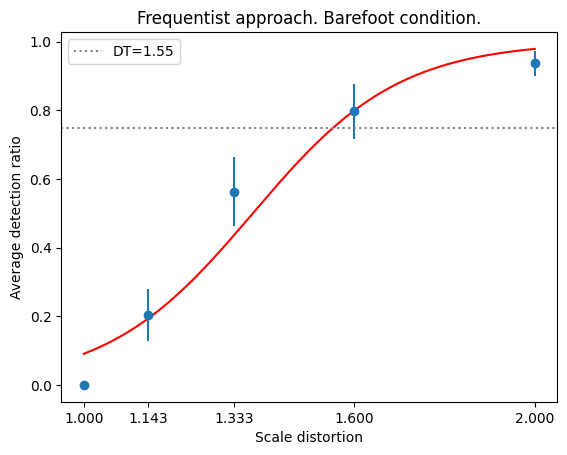

In [28]:
fit_psychometric_curve_logit("barefoot_scale.csv")

### Shod scale

Means  [0.046875 0.265625 0.46875  0.796875 0.9375  ]
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                    5
Model:                            GLM   Df Residuals:                        3
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1.5553
Date:                Mon, 02 Dec 2024   Deviance:                     0.097658
Time:                        02:38:24   Pearson chi2:                   0.0929
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3859
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

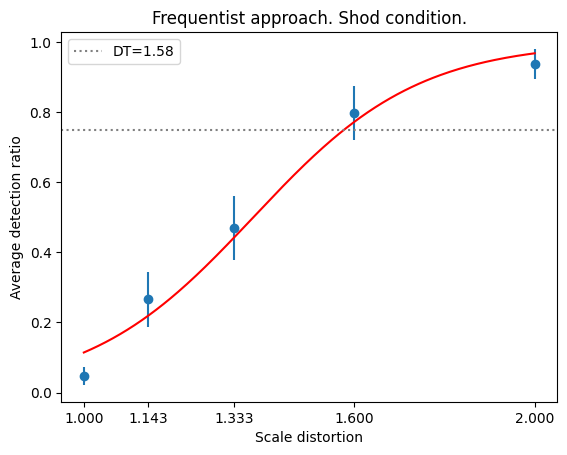

In [29]:
fit_psychometric_curve_logit("shod_scale.csv")

# Part 2: Bayesian approach

## Logistic regression

In [35]:
def fit_bayesian_psychometric_curve(filename):
  condition = "".join(filename.split("_")[:-1]).capitalize()
  stimulus = filename.split("_")[-1].split(".")[0].capitalize()

  data = get_data(filename)
  transformed_data = transform_data(data, condition=condition=='shod')
  data = get_y(data)
  y = np.array(data.mean(axis=0))
  std_err = data.sem()
  x_axis = get_x_axis(stimulus)

  with pm.Model() as logit:
      X_data = pm.Data("X_data", transformed_data["x"].to_numpy())
      y_data = pm.Data("y_data", transformed_data["y"].to_numpy())
      beta0 = pm.Normal("beta0", mu=0, sigma=10)
      beta1 = pm.Normal("beta1", mu=0, sigma=10)
      p = beta0 + beta1 * X_data
      likelihood = pm.Bernoulli("y", logit_p=p, observed=y_data)
      trace = pm.sample(5000, nuts_sampler="numpyro", random_seed=rng)

  print(az.summary(trace, hdi_prob=0.95))

  beta0_mean = trace.posterior["beta0"].values.mean()
  beta1_mean = trace.posterior["beta1"].values.mean()
  dt_x = get_detection_threshold([beta0_mean, beta1_mean], 0.75)

  print("\n")
  print(f"Coefficients: {[beta0_mean, beta1_mean]}")
  print(f"{stimulus} threshold: {dt_x} \n")

  pred_x = np.linspace(min(x_axis), max(x_axis), 50)
  pred_y = 1 / (1 + np.exp(-(beta0_mean + beta1_mean * pred_x)))
  plot_curve(x_axis, y, std_err,
             dt_x, condition,
             stimulus, pred_x, pred_y,
             analysis_type='Bayesian Logistic Regression')


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta0 -2.810  0.214    -3.219     -2.389      0.005    0.004    1714.0   
beta1  0.091  0.006     0.080      0.103      0.000    0.000    1822.0   

       ess_tail  r_hat  
beta0    2175.0    1.0  
beta1    1968.0    1.0  


Coefficients: [-2.809538965270976, 0.0913244176717712]
Angle threshold: 42.79415465845465 



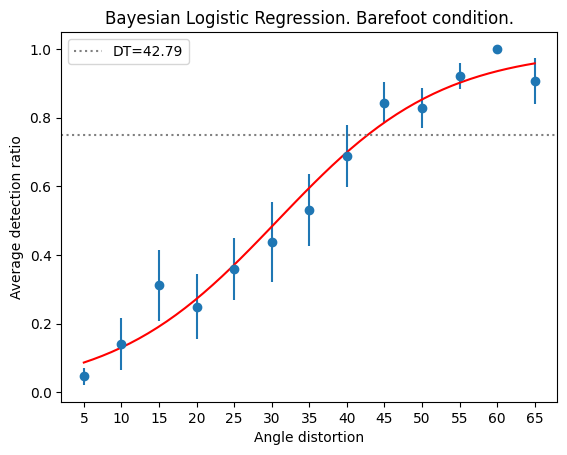

In [36]:
fit_bayesian_psychometric_curve("barefoot_angle.csv")

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta0 -2.909  0.213    -3.341     -2.499      0.004    0.003    2325.0   
beta1  0.088  0.006     0.077      0.100      0.000    0.000    2354.0   

       ess_tail  r_hat  
beta0    2918.0    1.0  
beta1    3042.0    1.0  


Coefficients: [-2.908805027445544, 0.08844078173368655]
Angle threshold: 45.311871260713346 



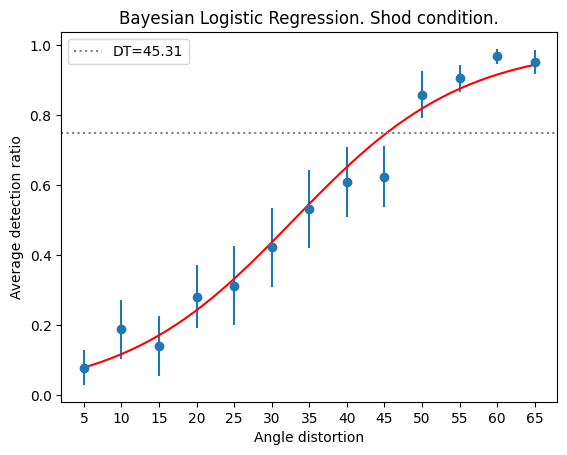

In [32]:
fit_bayesian_psychometric_curve("shod_angle.csv")

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta0 -8.430  0.858   -10.204     -6.826      0.021    0.015    1729.0   
beta1  6.143  0.636     4.867      7.377      0.015    0.011    1721.0   

       ess_tail  r_hat  
beta0    1913.0    1.0  
beta1    1934.0    1.0  


Coefficients: [-8.430427924406965, 6.143222766711715]
Scale threshold: 1.5511467799458762 



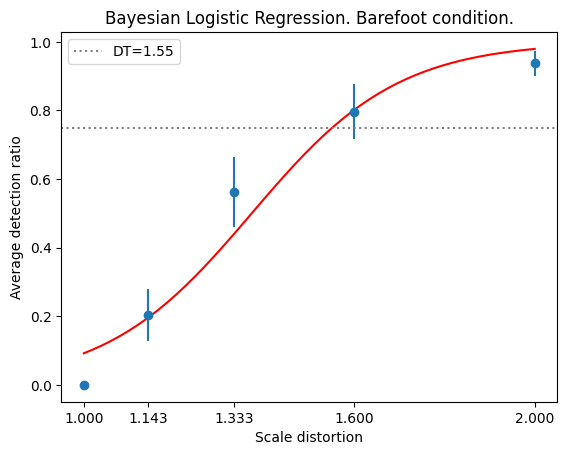

In [38]:
fit_bayesian_psychometric_curve("barefoot_scale.csv")

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta0 -7.491  0.816    -9.017     -5.901      0.021    0.015    1556.0   
beta1  5.454  0.600     4.249      6.555      0.015    0.011    1549.0   

       ess_tail  r_hat  
beta0    1823.0    1.0  
beta1    1877.0    1.0  


Coefficients: [-7.490763584443962, 5.453525404990027]
Scale threshold: 1.5750134518953027 



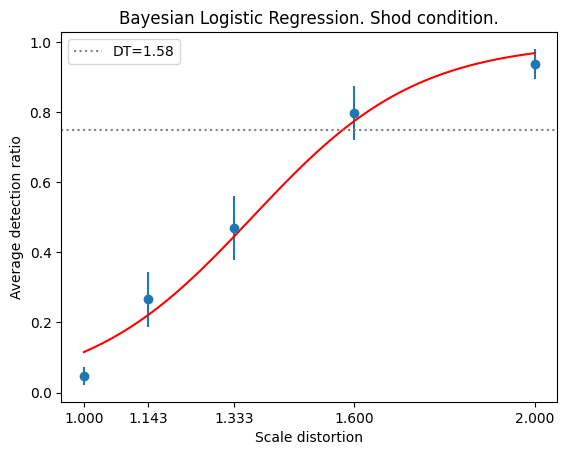

In [39]:
fit_bayesian_psychometric_curve("shod_scale.csv")

## Logistic regression with clusters

In [41]:
def fit_bayesian_psychometric_curve_cluster(filename):
  condition = "".join(filename.split("_")[:-1]).capitalize()
  stimulus = filename.split("_")[-1].split(".")[0].capitalize()

  data = get_data(filename)
  transformed_data = transform_data(data, condition=condition=='shod')
  data = get_y(data)
  y = np.array(data.mean(axis=0))
  std_err = data.sem()

  subject_idx, subjects = pd.factorize(transformed_data.subject_id)
  coords = {"subject": subjects, "id": transformed_data.index.to_numpy()}

  print(f"Subject: {subjects}")

  x_axis = get_x_axis(stimulus)

  with pm.Model(coords=coords) as logit:
      X_data = pm.Data("X_data", transformed_data["x"].to_numpy())
      y_data = pm.Data("y_data", transformed_data["y"].to_numpy())
      subj_idx = pm.Data("subject_idx", subject_idx, dims="id")

      beta0 = pm.Normal("beta0", mu=0, sigma=10)
      beta1 = pm.Normal("beta1", mu=0, sigma=10)

      tau_u = pm.Gamma("tau_u", 0.01, 0.01)
      subject_var = pm.Deterministic("sigma_u", 1 / tau_u)
      subject_effect = pm.Normal(
          "subject_effect", 0, tau=tau_u, dims="subject"
      )

      p = beta0 + beta1 * X_data + subject_effect[subj_idx]
      likelihood = pm.Bernoulli("y", logit_p=p, observed=y_data)
      trace = pm.sample(5000, nuts_sampler="numpyro", random_seed=rng)

  print(az.summary(trace, hdi_prob=0.95, var_names=['beta0', 'beta1', "sigma_u"]))

  beta0_mean = trace.posterior["beta0"].values.mean()
  beta1_mean = trace.posterior["beta1"].values.mean()
  dt_x = get_detection_threshold([beta0_mean, beta1_mean], 0.75)

  print("\n")
  print(f"Coefficients: {[beta0_mean, beta1_mean]}")
  print(f"{stimulus} threshold: {dt_x} \n")

  pred_x = np.linspace(min(x_axis), max(x_axis), 50)
  pred_y = 1 / (1 + np.exp(-(beta0_mean + beta1_mean * pred_x)))
  plot_curve(x_axis, y, std_err,
             dt_x, condition,
             stimulus, pred_x, pred_y,
             analysis_type='Random effect')

  az.plot_posterior(trace, var_names=["beta0", "beta1", "sigma_u"], hdi_prob=0.95)
  fig = plt.gcf()
  fig.tight_layout()
  plt.show()


Subject: Index([ 1.0,  2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0, 10.0, 11.0, 12.0,
       13.0, 14.0, 15.0, 16.0],
      dtype='float64')


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

          mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta0   -4.404  0.674    -5.722     -3.033      0.024    0.017     790.0   
beta1    0.144  0.011     0.124      0.165      0.000    0.000    2548.0   
sigma_u  5.020  2.448     1.769      9.708      0.053    0.039    2744.0   

         ess_tail  r_hat  
beta0      1210.0    1.0  
beta1      4660.0    1.0  
sigma_u    2737.0    1.0  


Coefficients: [-4.403689637528513, 0.14400078408955294]
Angle threshold: 38.21022198583853 



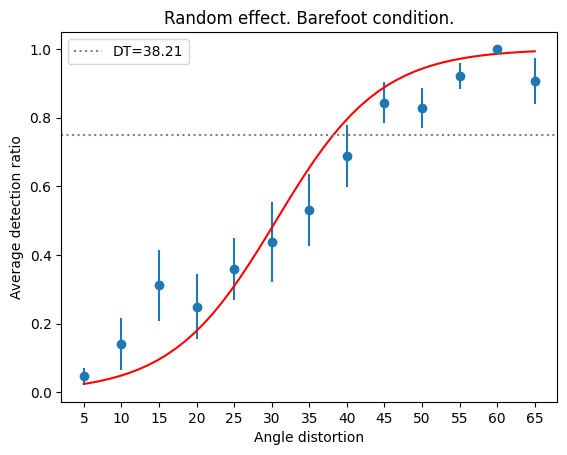

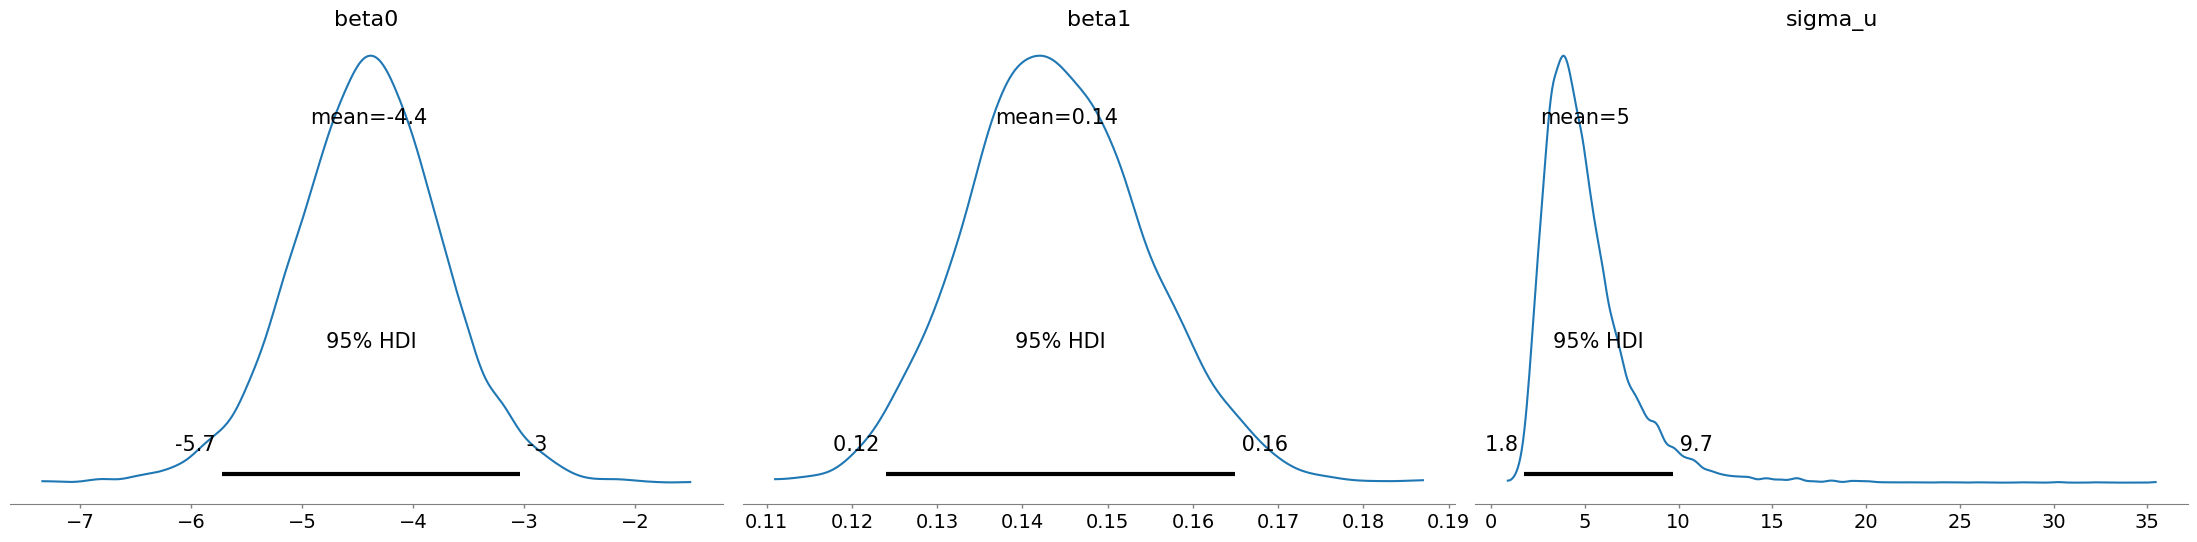

In [42]:
fit_bayesian_psychometric_curve_cluster("barefoot_angle.csv")

Subject: Index([ 1.0,  2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0, 10.0, 11.0, 12.0,
       13.0, 14.0, 15.0, 16.0],
      dtype='float64')


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

          mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta0   -5.385  0.873    -7.214     -3.786      0.029    0.021     885.0   
beta1    0.168  0.013     0.144      0.194      0.000    0.000    2566.0   
sigma_u  9.396  4.244     3.144     17.690      0.073    0.052    3371.0   

         ess_tail  r_hat  
beta0      1812.0    1.0  
beta1      4280.0    1.0  
sigma_u    4936.0    1.0  


Coefficients: [-5.384500593161114, 0.16772992321781321]
Angle threshold: 38.65209473333084 



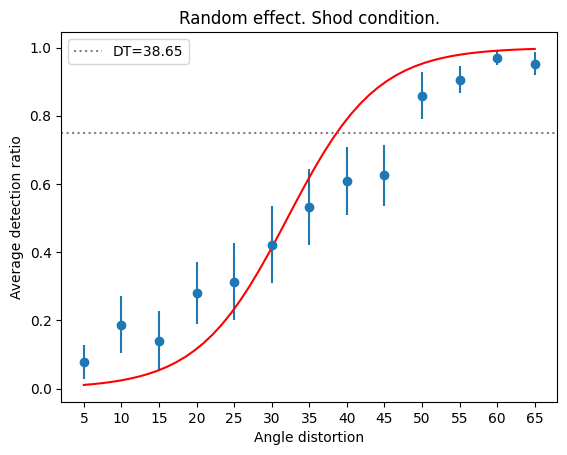

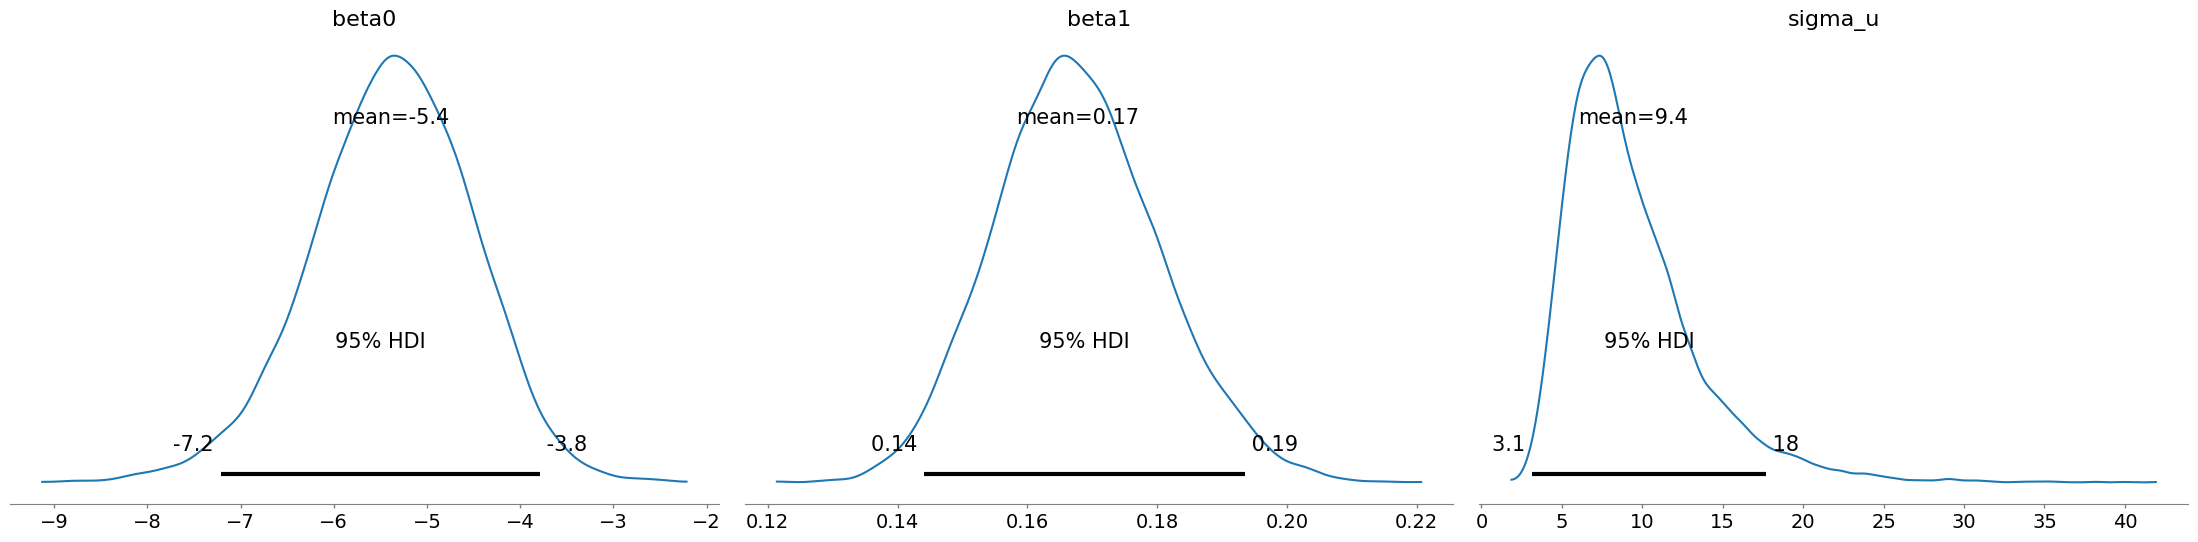

In [43]:
fit_bayesian_psychometric_curve_cluster("shod_angle.csv")

Subject: Index([ 1.0,  2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0, 10.0, 11.0, 12.0,
       13.0, 14.0, 15.0, 16.0],
      dtype='float64')


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta0   -12.796  1.603   -16.014     -9.777      0.036    0.025    2020.0   
beta1     9.303  1.125     7.202     11.537      0.023    0.016    2343.0   
sigma_u   4.755  2.538     1.236      9.862      0.044    0.031    3056.0   

         ess_tail  r_hat  
beta0      3113.0    1.0  
beta1      3572.0    1.0  
sigma_u    4967.0    1.0  


Coefficients: [-12.795793776184833, 9.302822252253915]
Scale threshold: 1.4935689071654106 



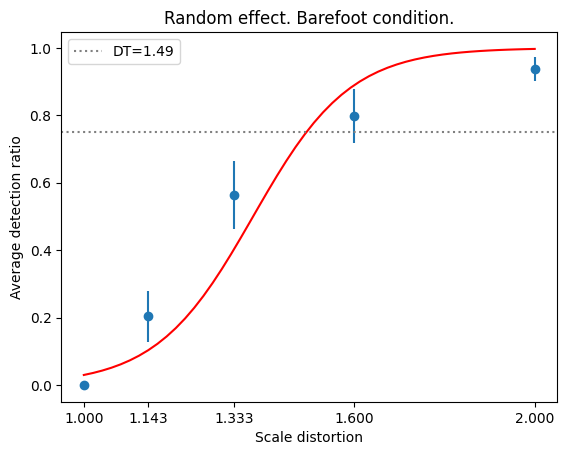

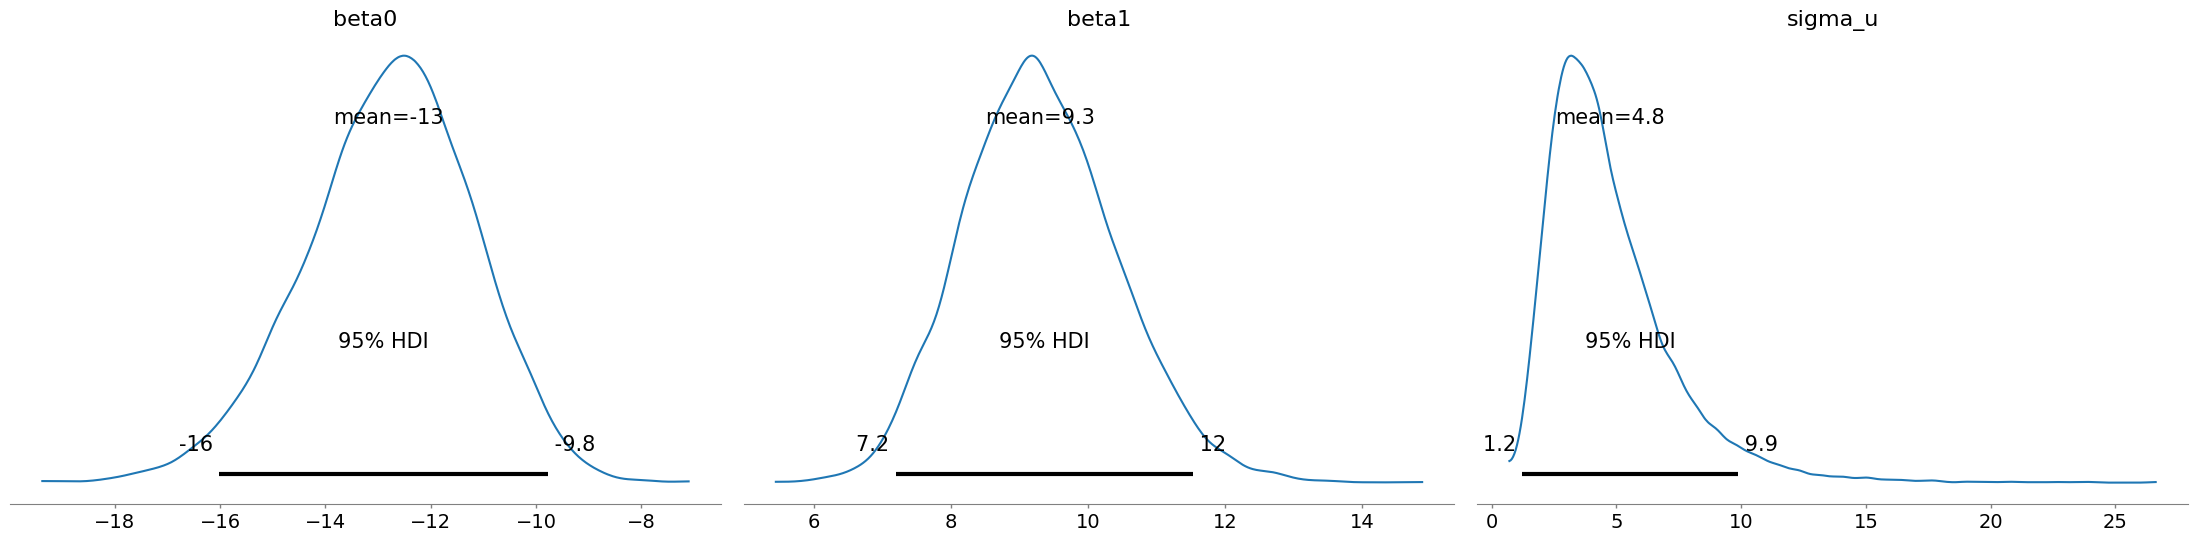

In [44]:
fit_bayesian_psychometric_curve_cluster("barefoot_scale.csv")

Subject: Index([ 1.0,  2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0, 10.0, 11.0, 12.0,
       13.0, 14.0, 15.0, 16.0],
      dtype='float64')


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

          mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta0   -9.529  1.146   -11.844     -7.371      0.020    0.014    3428.0   
beta1    6.925  0.798     5.394      8.495      0.012    0.009    4163.0   
sigma_u  2.078  1.213     0.456      4.400      0.018    0.013    4073.0   

         ess_tail  r_hat  
beta0      4515.0    1.0  
beta1      5615.0    1.0  
sigma_u    5927.0    1.0  


Coefficients: [-9.528610839567087, 6.925027505434242]
Scale threshold: 1.5346109629016995 



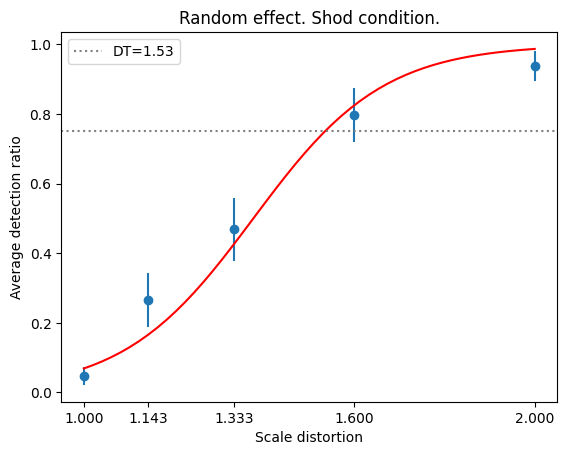

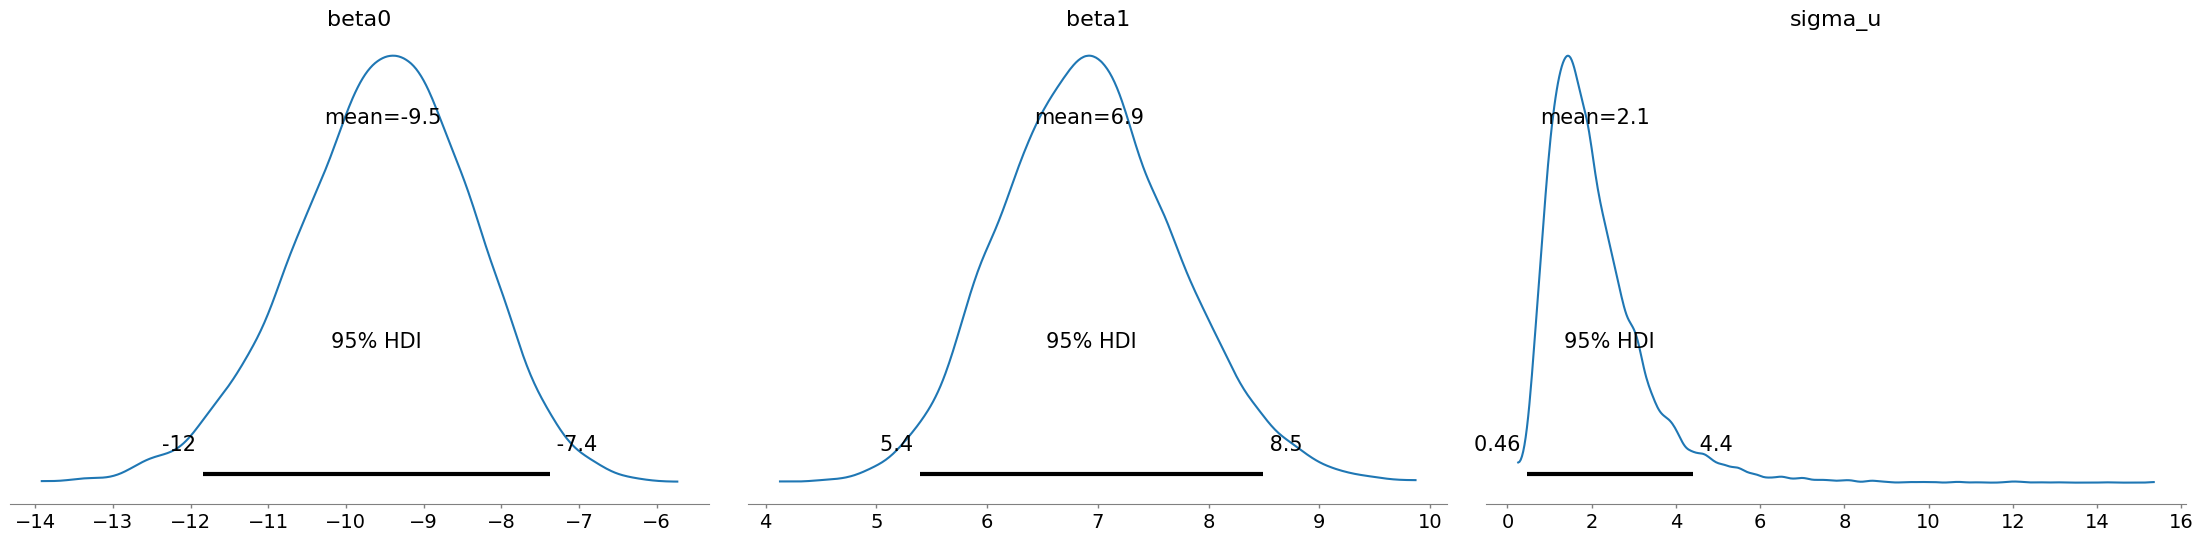

In [45]:
fit_bayesian_psychometric_curve_cluster("shod_scale.csv")

## Wichmann And Hill

In [47]:
def fit_bayesian_psychometric_curve_wh(filename, fixed_gamma=False):
  condition = "".join(filename.split("_")[:-1]).capitalize()
  stimulus = filename.split("_")[-1].split(".")[0].capitalize()

  data = get_data(filename)
  transformed_data = transform_data(data, condition=condition=='shod')
  data = get_y(data)
  y = np.array(data.mean(axis=0))
  std_err = data.sem()

  x_axis = get_x_axis(stimulus)

  with pm.Model() as logit:
      X_data = pm.Data("X_data", transformed_data["x"].to_numpy())
      y_data = pm.Data("y_data", transformed_data["y"].to_numpy())

      if fixed_gamma:
        gamma = 0.5
        lambda_unscaled = pm.Beta("lambda_unscaled", alpha=2, beta=50)
        lambda_ = pm.Deterministic("lambda", lambda_unscaled * 0.06)
      else:
        gamma = pm.Beta("gamma", alpha=2, beta=50)
        lambda_ = pm.Beta("lambda", alpha=2, beta=50)

      beta0 = pm.Normal("beta0", mu=0, sigma=5)
      beta1 = pm.HalfNormal("beta1", sigma=2)

      p = gamma + (1- gamma - lambda_) / (1 + pm.math.exp(-(beta0 + beta1 * X_data)))

      likelihood = pm.Bernoulli("y", p=p, observed=y_data)
      trace = pm.sample(5000, nuts_sampler="numpyro", target_accept=0.95, init="jitter+adapt_diag")

  print(az.summary(trace, hdi_prob=0.95))

  beta0_mean = trace.posterior["beta0"].values.mean()
  beta1_mean = trace.posterior["beta1"].values.mean()
  lambda_mean = trace.posterior["lambda"].values.mean()
  if fixed_gamma:
    gamma_mean = 0.5
  else:
    gamma_mean = trace.posterior["gamma"].values.mean()

  threshold = (0.75 - gamma_mean) / (1 - gamma_mean - lambda_mean)
  dt_x = (np.log(threshold / (1 - threshold)) - beta0_mean) / beta1_mean

  print("\n")
  print(f"Coefficients: {[beta0_mean, beta1_mean]}")
  print(f"{stimulus} threshold: {dt_x} \n")

  pred_x = np.linspace(min(x_axis), max(x_axis), 50)
  pred_y = gamma_mean + (1 - gamma_mean - lambda_mean) / (1 + np.exp(-(beta0_mean + beta1_mean * pred_x)))
  plot_curve(x_axis, y, std_err,
             dt_x, condition, stimulus,
             pred_x, pred_y,
             analysis_type='Wichmann & Hall')

  if not fixed_gamma:
    az.plot_posterior(trace, var_names=["beta0", "beta1", "gamma", "lambda"], hdi_prob=0.95)
  else:
    az.plot_posterior(trace, var_names=["beta0", "beta1", "lambda"], hdi_prob=0.95)
  fig = plt.gcf()
  fig.tight_layout()
  plt.show()


### Barefoot Angle

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

         mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta0  -3.244  0.388    -3.999     -2.536      0.008    0.006    2481.0   
beta1   0.104  0.011     0.086      0.126      0.000    0.000    2523.0   
gamma   0.039  0.024     0.002      0.086      0.000    0.000    2904.0   
lambda  0.027  0.015     0.002      0.056      0.000    0.000    3962.0   

        ess_tail  r_hat  
beta0     2105.0    1.0  
beta1     2275.0    1.0  
gamma     3414.0    1.0  
lambda    3419.0    1.0  


Coefficients: [-3.2435479689948568, 0.10430893846652482]
Angle threshold: 42.216220062616266 



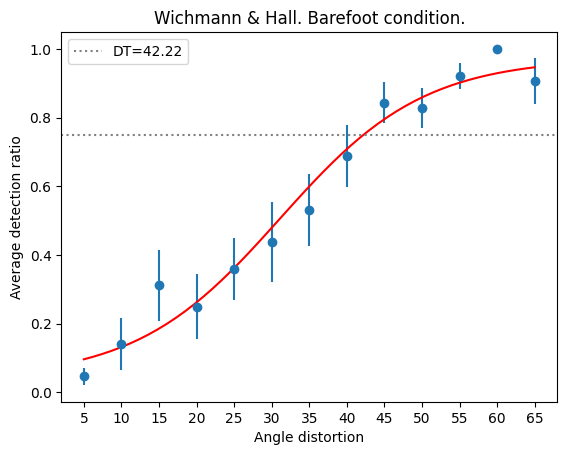

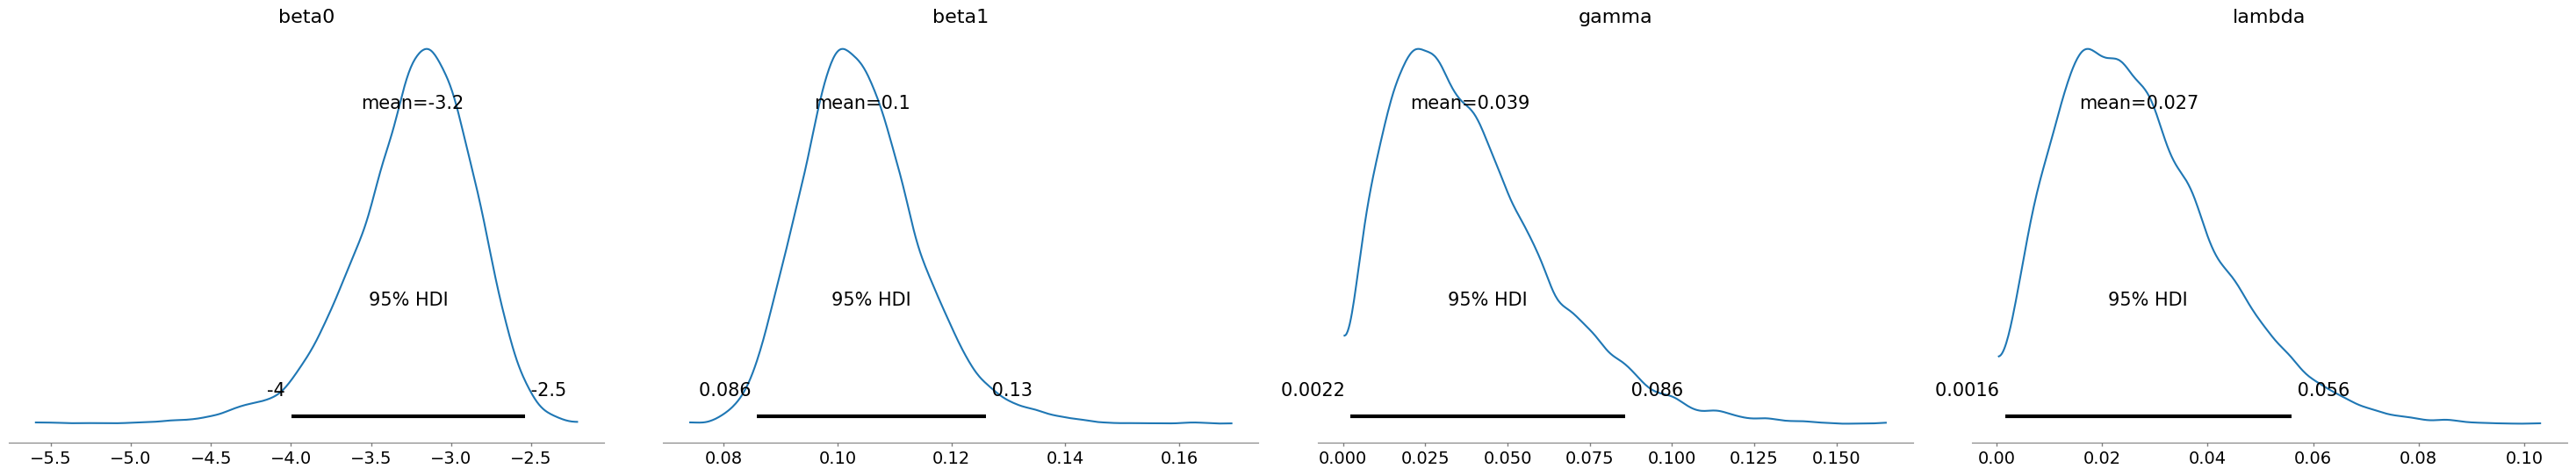

In [48]:
fit_bayesian_psychometric_curve_wh("barefoot_angle.csv", fixed_gamma=False)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

                  mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
beta0           -7.671  0.971    -9.654     -5.854      0.017    0.012   
beta1            0.170  0.021     0.133      0.214      0.000    0.000   
lambda           0.003  0.002     0.000      0.007      0.000    0.000   
lambda_unscaled  0.048  0.033     0.001      0.114      0.001    0.000   

                 ess_bulk  ess_tail  r_hat  
beta0              3366.0    2753.0    1.0  
beta1              3365.0    2799.0    1.0  
lambda             3250.0    2410.0    1.0  
lambda_unscaled    3250.0    2410.0    1.0  


Coefficients: [-7.670593396772321, 0.16987208282347357]
Angle threshold: 45.223317029980706 



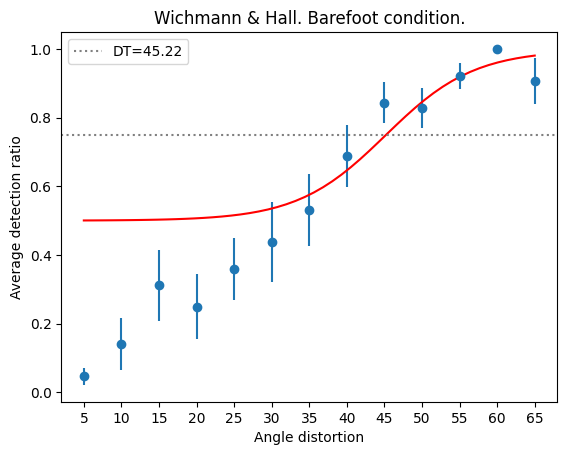

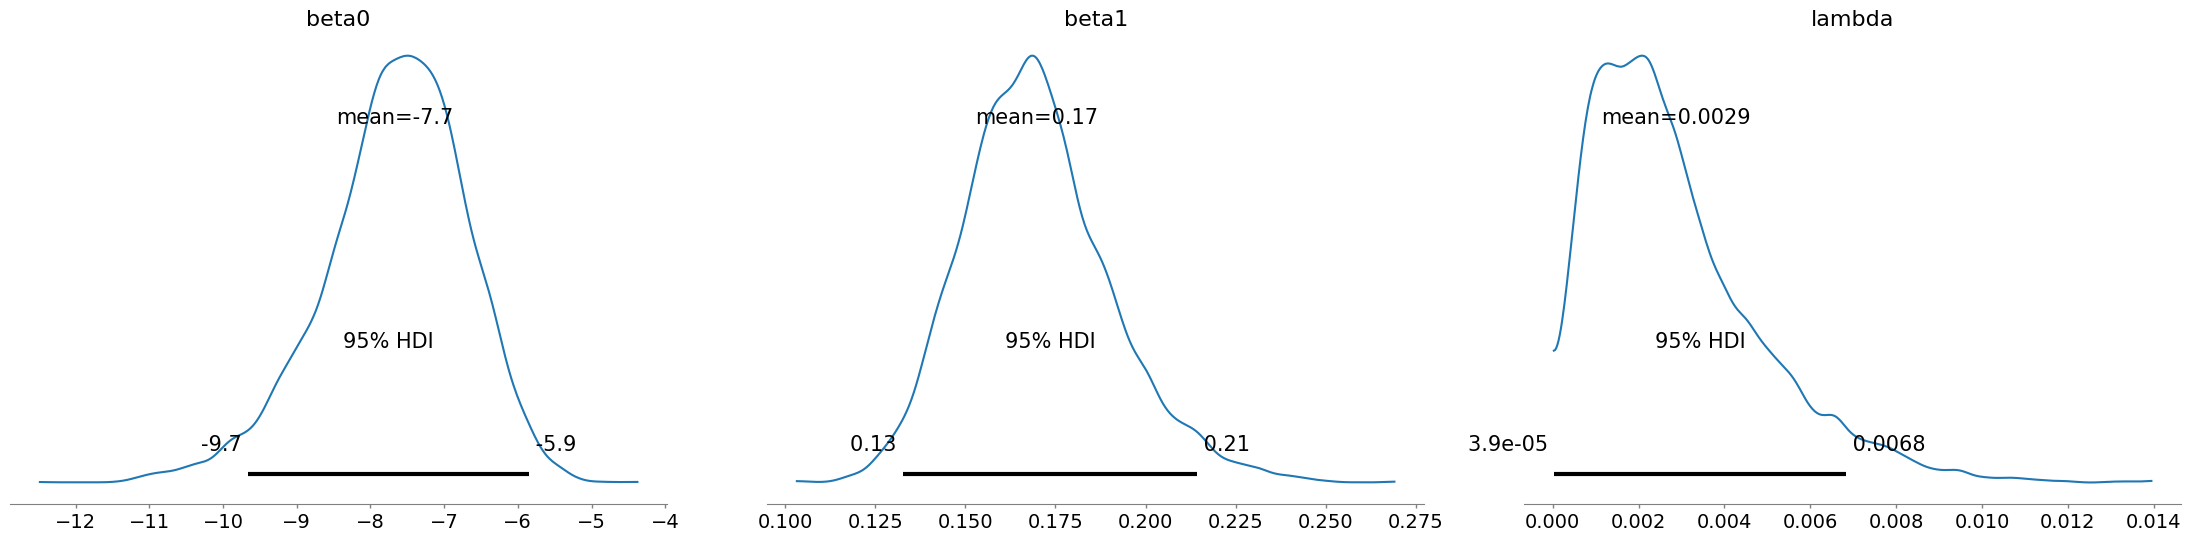

In [52]:
fit_bayesian_psychometric_curve_wh("barefoot_angle.csv", fixed_gamma=True)

### Shod angle

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

         mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta0  -3.494  0.460    -4.425     -2.694      0.010    0.008    2295.0   
beta1   0.102  0.011     0.083      0.123      0.000    0.000    2444.0   
gamma   0.052  0.029     0.004      0.107      0.001    0.000    2474.0   
lambda  0.021  0.013     0.001      0.045      0.000    0.000    3301.0   

        ess_tail  r_hat  
beta0     2220.0    1.0  
beta1     2298.0    1.0  
gamma     3216.0    1.0  
lambda    3131.0    1.0  


Coefficients: [-3.493669445551948, 0.10213953461653075]
Angle threshold: 45.10222432349732 



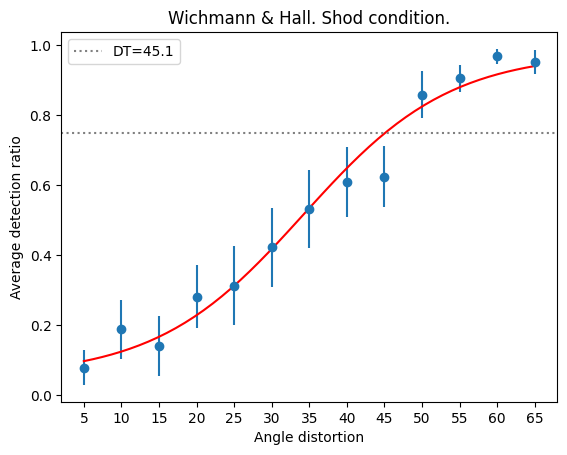

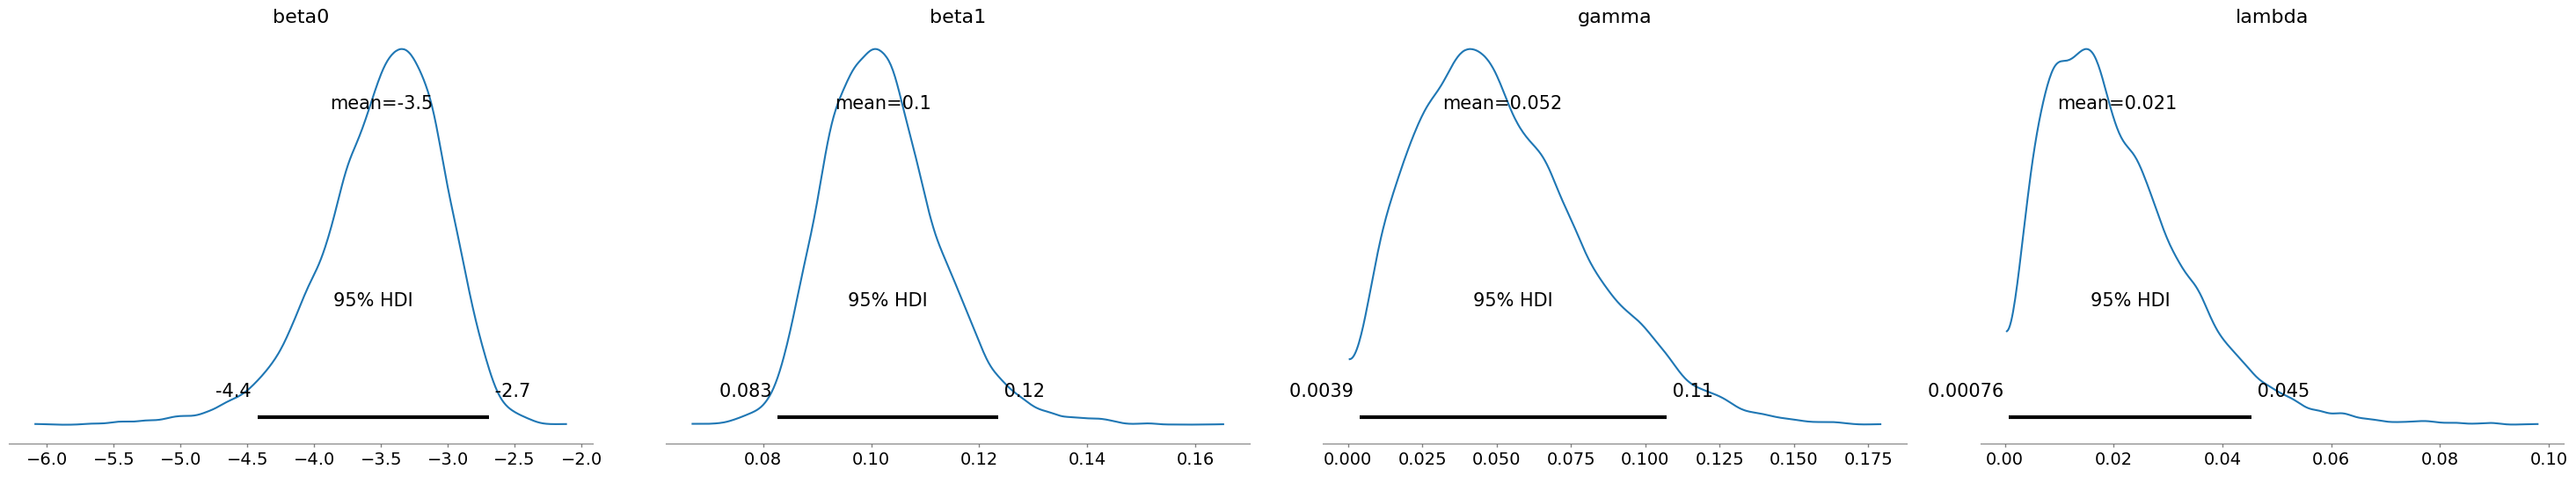

In [49]:
fit_bayesian_psychometric_curve_wh("shod_angle.csv", fixed_gamma=False)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

                  mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
beta0           -9.682  1.382   -12.442     -7.109      0.027    0.019   
beta1            0.202  0.028     0.149      0.256      0.001    0.000   
lambda           0.003  0.002     0.000      0.006      0.000    0.000   
lambda_unscaled  0.044  0.030     0.001      0.101      0.001    0.000   

                 ess_bulk  ess_tail  r_hat  
beta0              2742.0    3027.0    1.0  
beta1              2747.0    2845.0    1.0  
lambda             3173.0    3851.0    1.0  
lambda_unscaled    3173.0    3851.0    1.0  


Coefficients: [-9.681672075940789, 0.2022667829094776]
Angle threshold: 47.91807020493739 



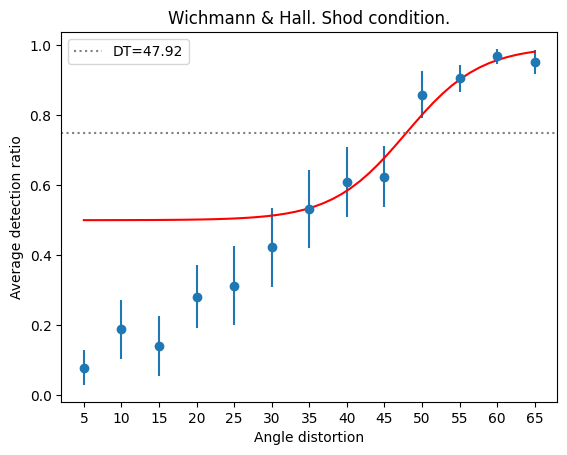

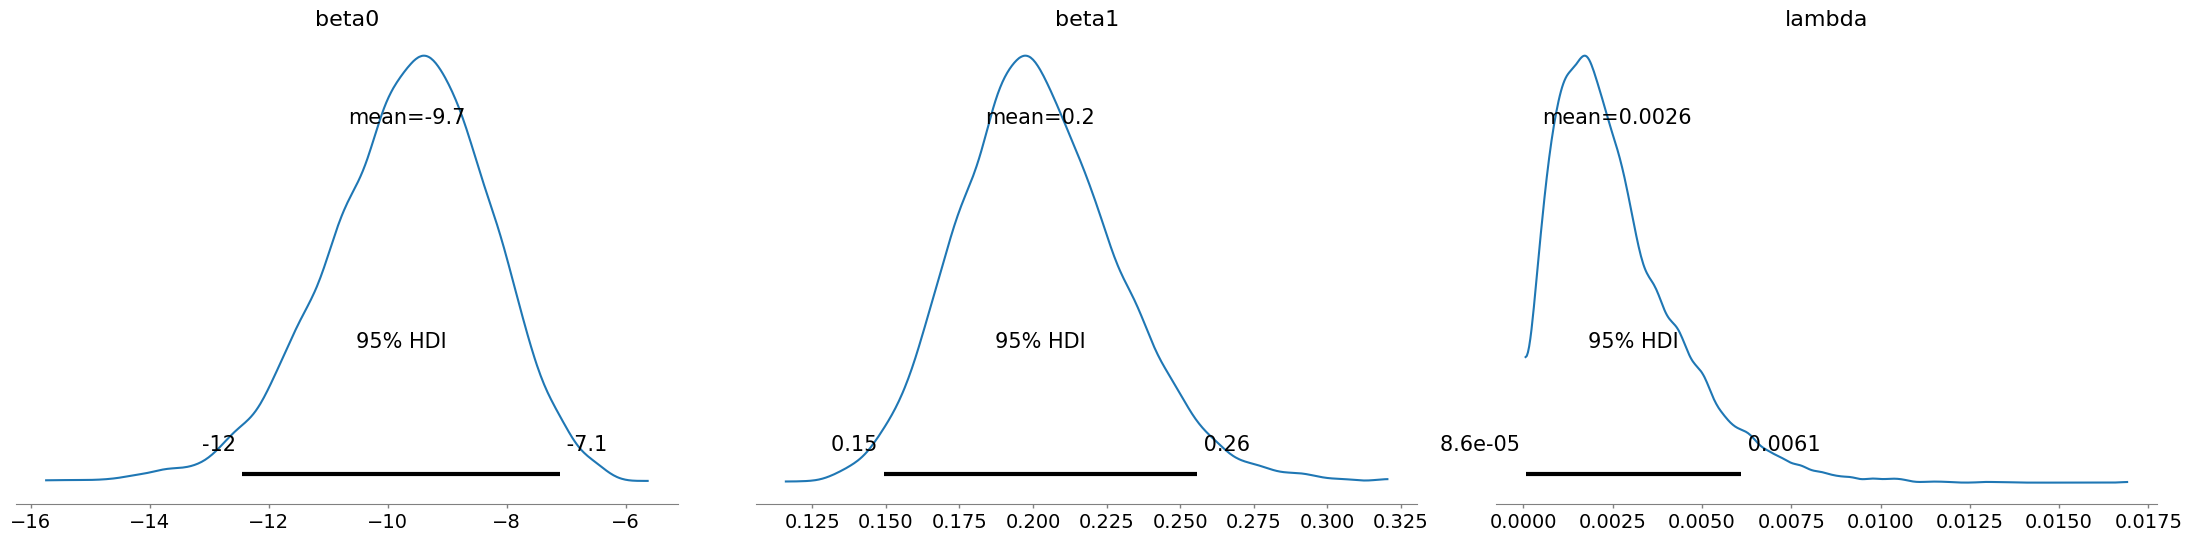

In [53]:
fit_bayesian_psychometric_curve_wh("shod_angle.csv", fixed_gamma=True)

### Barefoot scale

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

         mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta0  -8.616  1.032   -10.644     -6.644      0.018    0.013    3380.0   
beta1   6.371  0.806     4.836      7.965      0.014    0.010    3316.0   
gamma   0.019  0.013     0.000      0.044      0.000    0.000    4173.0   
lambda  0.039  0.021     0.005      0.079      0.000    0.000    4158.0   

        ess_tail  r_hat  
beta0     3912.0    1.0  
beta1     4035.0    1.0  
gamma     3423.0    1.0  
lambda    2895.0    1.0  


Coefficients: [-8.616144000803306, 6.3706316670160605]
Scale threshold: 1.5476462134434243 



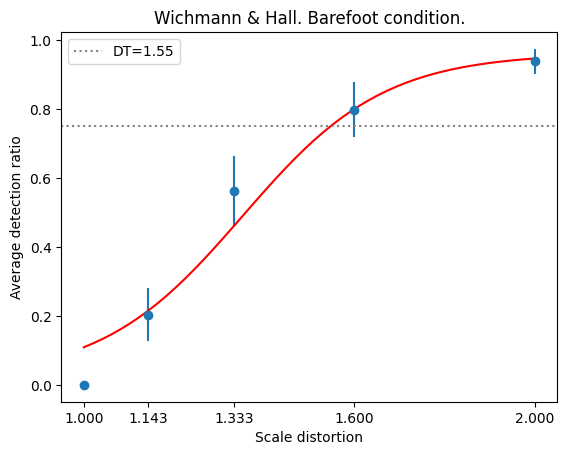

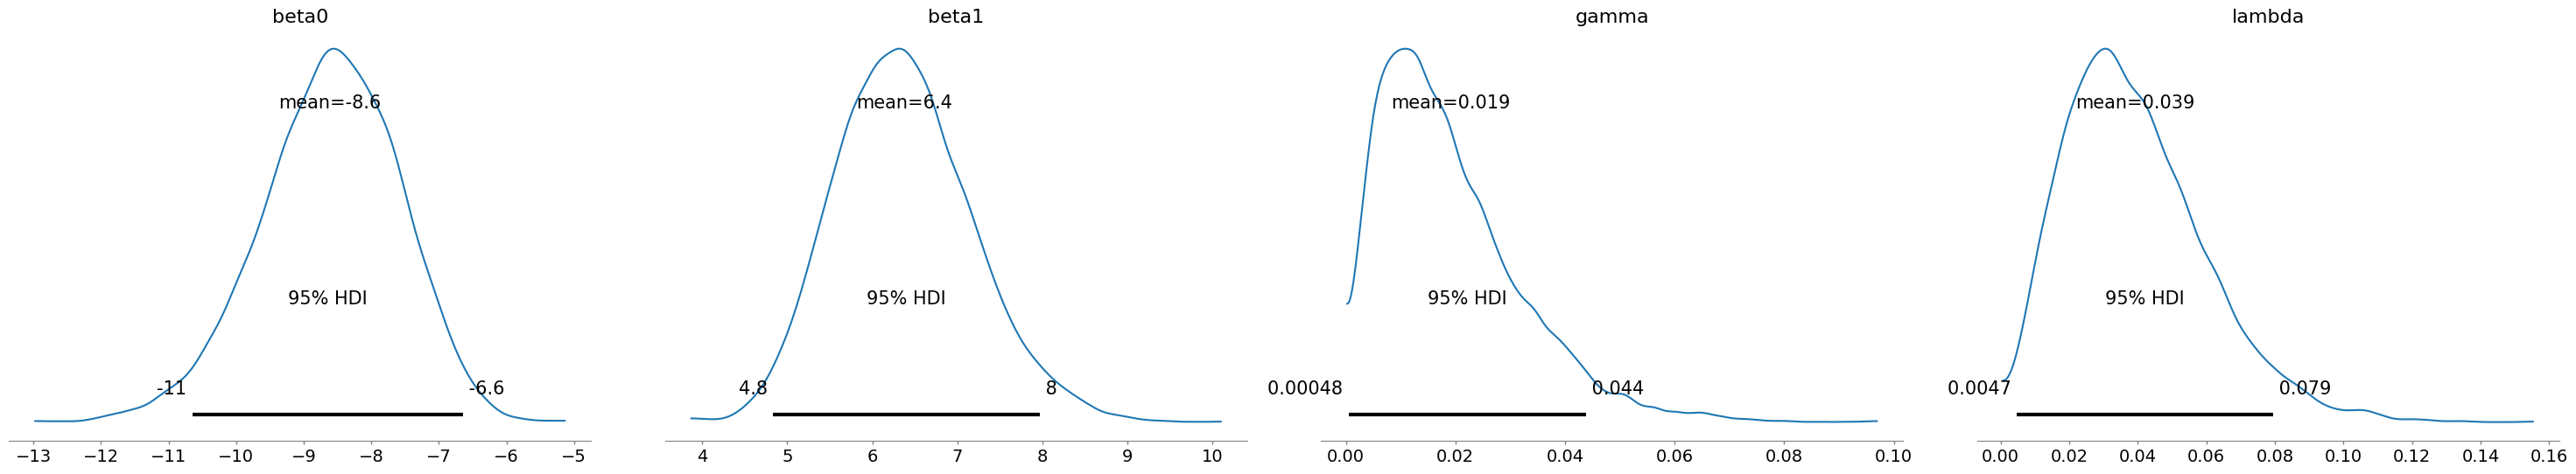

In [50]:
fit_bayesian_psychometric_curve_wh("barefoot_scale.csv", fixed_gamma=False)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

                  mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
beta0           -9.524  1.195   -11.737     -7.153      0.023    0.016   
beta1            5.740  0.758     4.265      7.182      0.014    0.010   
lambda           0.002  0.002     0.000      0.005      0.000    0.000   
lambda_unscaled  0.038  0.027     0.001      0.090      0.000    0.000   

                 ess_bulk  ess_tail  r_hat  
beta0              2675.0    3554.0    1.0  
beta1              2759.0    3570.0    1.0  
lambda             3431.0    2987.0    1.0  
lambda_unscaled    3431.0    2987.0    1.0  


Coefficients: [-9.523529152033928, 5.740386622389228]
Scale threshold: 1.660655182695517 



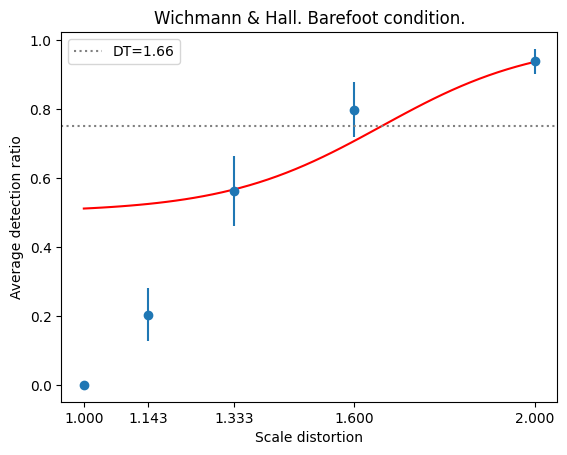

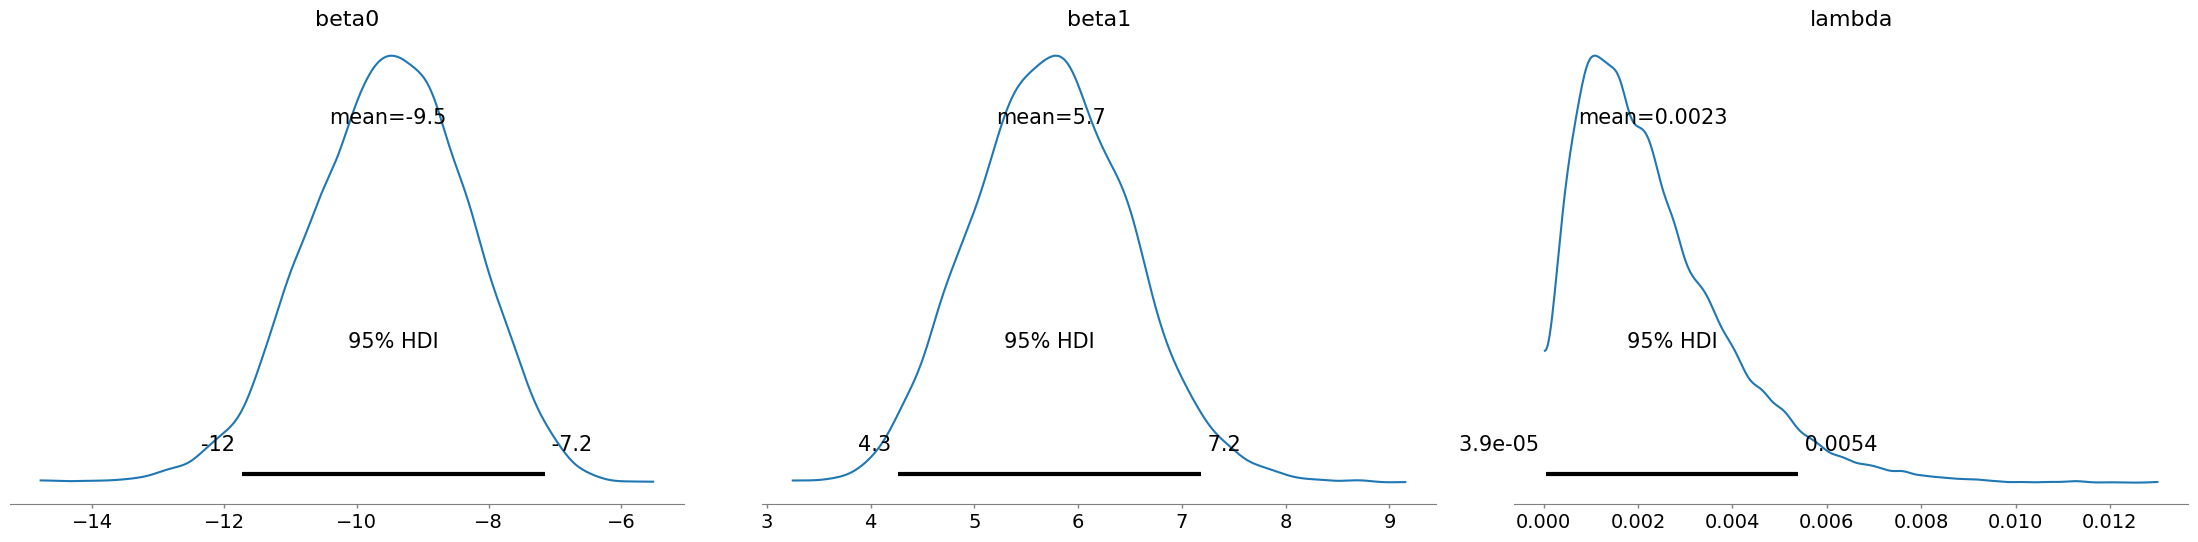

In [54]:
fit_bayesian_psychometric_curve_wh("barefoot_scale.csv", fixed_gamma=True)

### Shod scale

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

         mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta0  -7.605  0.933    -9.507     -5.912      0.016    0.012    3327.0   
beta1   5.574  0.711     4.316      7.035      0.012    0.009    3324.0   
gamma   0.026  0.017     0.000      0.059      0.000    0.000    5182.0   
lambda  0.034  0.019     0.002      0.071      0.000    0.000    4659.0   

        ess_tail  r_hat  
beta0     3842.0    1.0  
beta1     3853.0    1.0  
gamma     4195.0    1.0  
lambda    3357.0    1.0  


Coefficients: [-7.6048736639625565, 5.574261998128699]
Scale threshold: 1.5809241658944106 



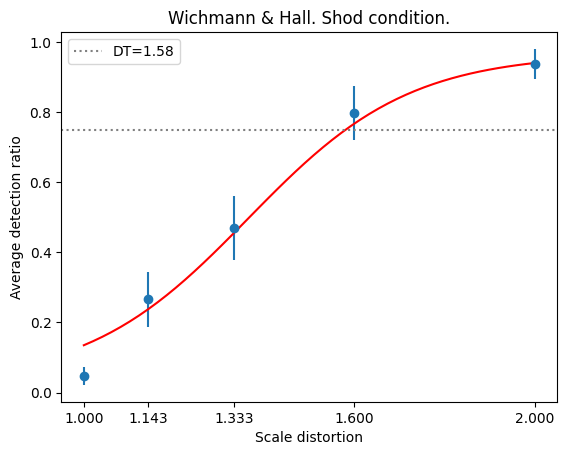

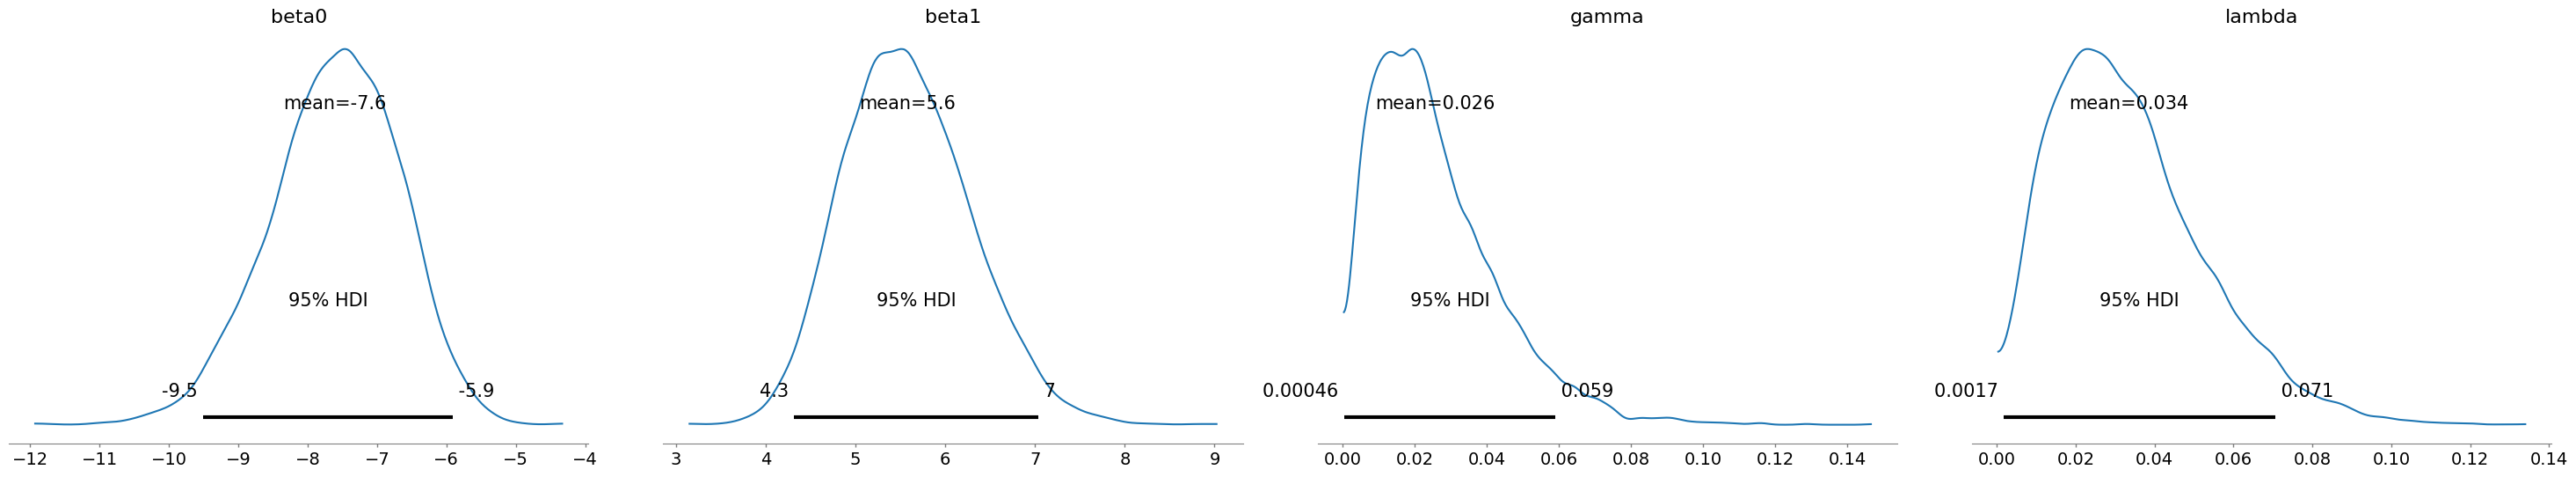

In [51]:
fit_bayesian_psychometric_curve_wh("shod_scale.csv", fixed_gamma=False)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

                  mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
beta0           -9.635  1.219   -12.067     -7.234      0.022    0.015   
beta1            5.764  0.764     4.307      7.306      0.014    0.010   
lambda           0.002  0.002     0.000      0.005      0.000    0.000   
lambda_unscaled  0.039  0.027     0.001      0.091      0.000    0.000   

                 ess_bulk  ess_tail  r_hat  
beta0              3206.0    3696.0    1.0  
beta1              3093.0    3935.0    1.0  
lambda             3781.0    3334.0    1.0  
lambda_unscaled    3781.0    3334.0    1.0  


Coefficients: [-9.634945215319119, 5.763685326767179]
Scale threshold: 1.6732856738487927 



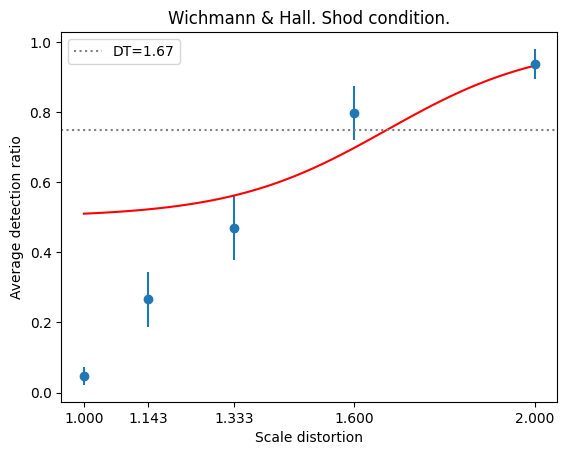

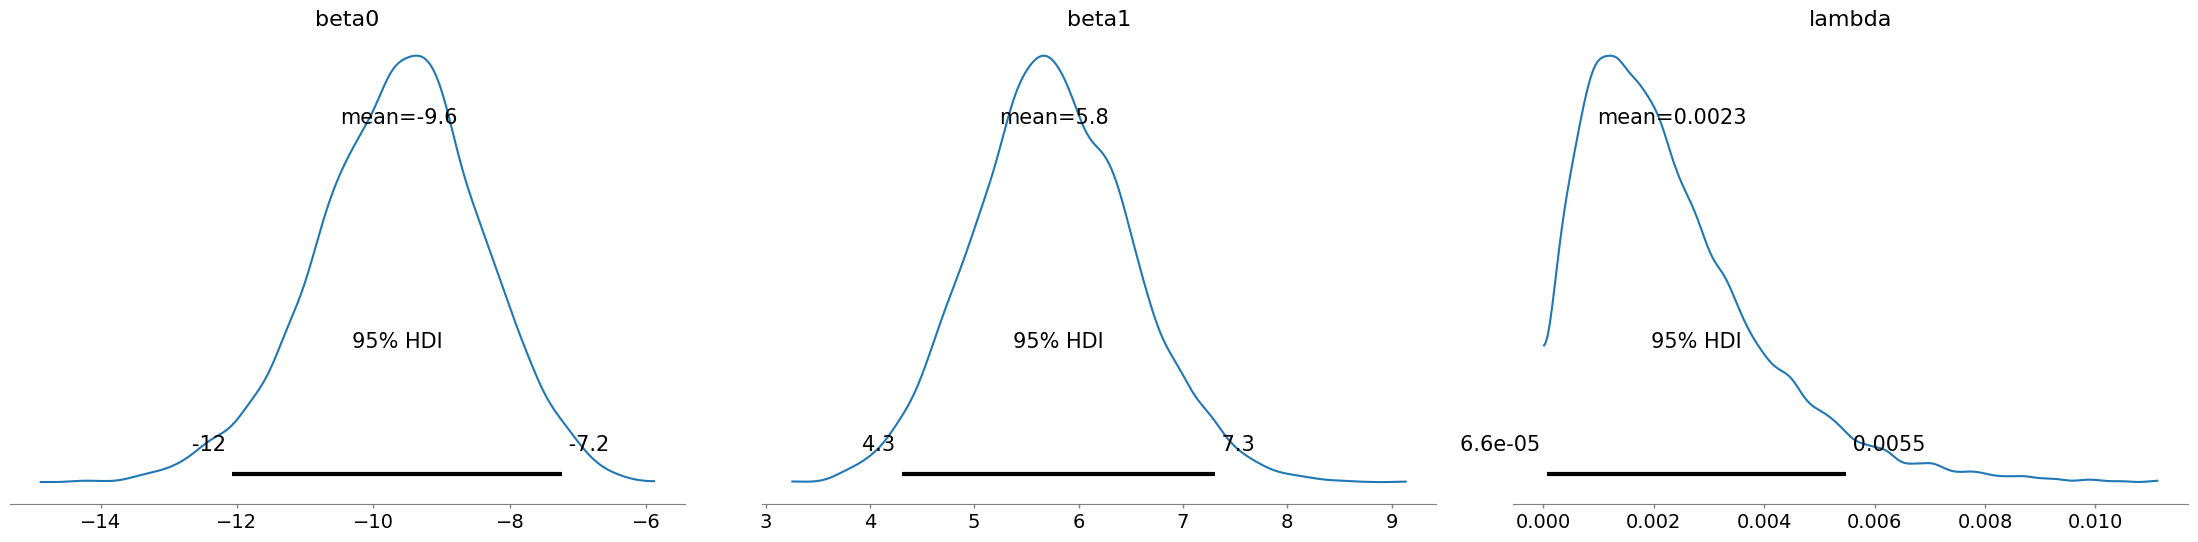

In [55]:
fit_bayesian_psychometric_curve_wh("shod_scale.csv", fixed_gamma=True)

# Part 3: Test variance

In [60]:
def test_variance(b_filename, s_filename, stimulus):
  barefoot_data = get_data(b_filename)
  barefoot_data = get_y(barefoot_data)
  barefoot_y = np.array(barefoot_data.mean(axis=0))

  shod_data = get_data(s_filename)
  shod_data = get_y(shod_data)
  shod_y = np.array(shod_data.mean(axis=0))

  x_axis = get_x_axis(stimulus)

  with pm.Model() as logit:

      mu0 = [pm.Normal(f"μ0{i}", mu=0, tau=0.0001) for i in range(len(x_axis))]
      tau = pm.Gamma("τ", 0.001, 0.001)

      alphas = [pm.Normal(f"α{i+1}b", mu=0, tau=0.0001) for i in range(len(x_axis))]

      # sum-to-zero constraint
      for i in range(len(x_axis)):
        alphas.append(pm.Deterministic(f"α{i+1}s", -alphas[i]))

      mus = [
          pm.Deterministic(f"mu{i + 1}b", mu0[i] + alpha) for i, alpha in enumerate(alphas[:-len(x_axis)])
      ]
      mus += [
          pm.Deterministic(f"mu{i + 1}s", mu0[i] + alpha) for i, alpha in enumerate(alphas[-len(x_axis):])
      ]

      likelihoods = [
          pm.Normal(f"lik{i + 1}b", mu=mus[i], tau=tau, observed=barefoot_data.iloc[:, i]) for i in range(len(x_axis))
      ]
      likelihoods += [
          pm.Normal(f"lik{i + 1}s", mu=mus[i+len(x_axis)], tau=tau, observed=shod_data.iloc[:, i]) for i in range(len(x_axis))
      ]

      [pm.Deterministic(f"α{i + 1}b - α{i + 1}s", alphas[i] - alphas[i+len(x_axis)]) for i in range(len(x_axis))]

      trace = pm.sample(5000, nuts_sampler="numpyro")

  print(az.summary(trace, var_names=[f"α{i+1}b - α{i+1}s" for i in range(len(x_axis))], hdi_prob=0.95))
  az.plot_forest(
    trace, var_names=[f"α{i+1}b - α{i+1}s" for i in range(len(x_axis))], combined=True
  )

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

              mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
α1b - α1s   -0.033  0.115    -0.248      0.203      0.001    0.001   21804.0   
α2b - α2s   -0.047  0.113    -0.270      0.171      0.001    0.001   20792.0   
α3b - α3s    0.171  0.114    -0.048      0.402      0.001    0.001   23204.0   
α4b - α4s   -0.030  0.115    -0.263      0.188      0.001    0.001   21707.0   
α5b - α5s    0.048  0.114    -0.184      0.267      0.001    0.001   19028.0   
α6b - α6s    0.016  0.116    -0.212      0.241      0.001    0.001   23685.0   
α7b - α7s    0.000  0.112    -0.213      0.227      0.001    0.001   23191.0   
α8b - α8s    0.076  0.115    -0.156      0.291      0.001    0.001   22759.0   
α9b - α9s    0.219  0.114    -0.010      0.440      0.001    0.001   26223.0   
α10b - α10s -0.031  0.113    -0.246      0.195      0.001    0.001   20151.0   
α11b - α11s  0.015  0.115    -0.210      0.240      0.001    0.001   22060.0   
α12b - α12s  0.032  0.112    -0.182     

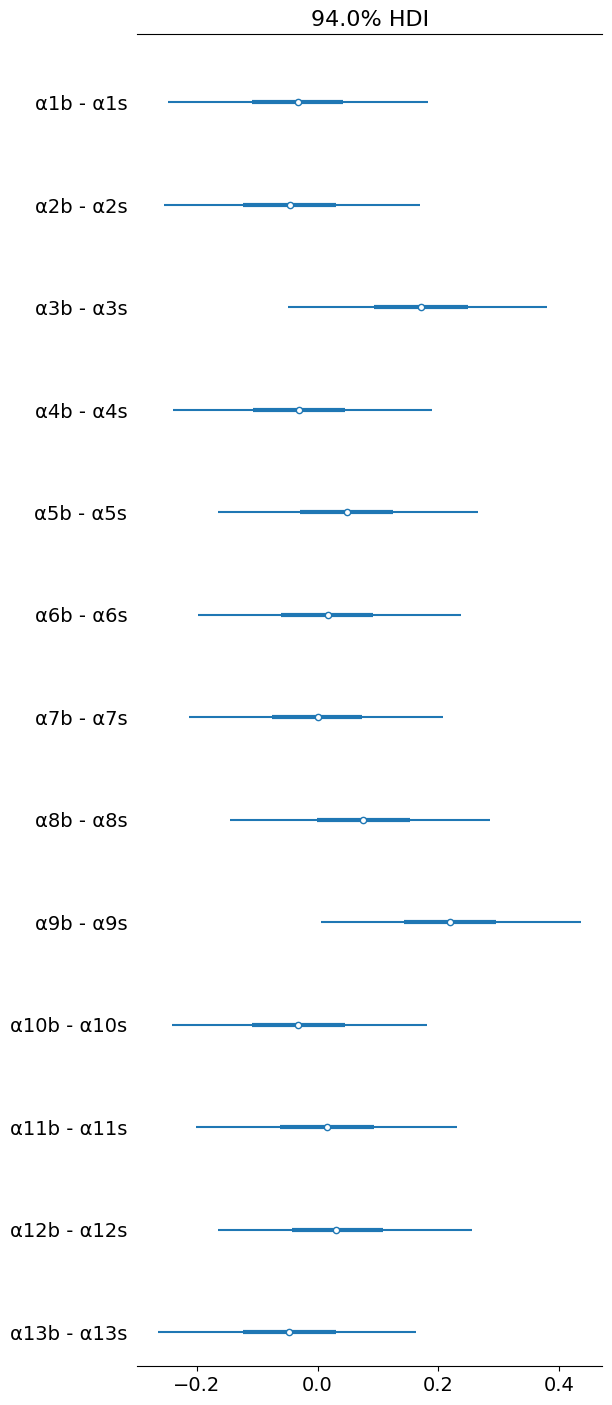

In [61]:
test_variance("barefoot_angle.csv", "shod_angle.csv", "Angle")

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

            mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
α1b - α1s -0.047  0.097    -0.239      0.146      0.001    0.001   22279.0   
α2b - α2s -0.061  0.095    -0.249      0.125      0.001    0.001   22560.0   
α3b - α3s  0.093  0.097    -0.094      0.281      0.001    0.001   20834.0   
α4b - α4s -0.001  0.096    -0.188      0.190      0.001    0.001   22150.0   
α5b - α5s  0.000  0.096    -0.182      0.190      0.001    0.001   19746.0   

           ess_tail  r_hat  
α1b - α1s    6747.0    1.0  
α2b - α2s    7401.0    1.0  
α3b - α3s    8405.0    1.0  
α4b - α4s    7684.0    1.0  
α5b - α5s    7159.0    1.0  


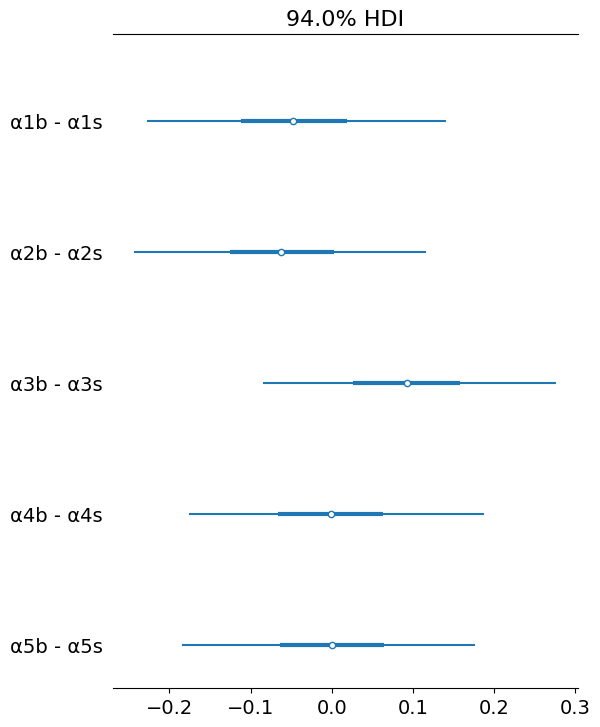

In [62]:
test_variance("barefoot_scale.csv", "shod_scale.csv", "Scale")